In [43]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.special import expit, logit
from sklearn.linear_model import LogisticRegression

# グラフ描画用
import matplotlib.pyplot as plt
import plotnine as pln
from plotnine import ggplot, aes
from plotnine.geoms import *
from plotnine.stats import *
from plotnine.scales import *
from plotnine.themes import theme, element_text, element_blank
from plotnine.labels import labs
from mlxtend.plotting import plot_decision_regions

# plotnine 初期設定
pln.options.figure_size = (10, 10)  # サイズ
pln.options.current_theme = pln.theme(
    title=pln.element_text(family='IPAGothic', size=20), # フォント変更
    legend_title=pln.element_text(family='IPAGothic', size=16), # フォント変更
    text=pln.element_text(family='IPAGothic', size=14),
    aspect_ratio=1.0
)

In [2]:
np.random.seed(42)
n = 1000
# 実際の境界線
logisCurve = lambda x: expit((x - .5) * 10)
# データ
df = pd.DataFrame({'x': np.random.uniform(low=0, high=1, size=n),
                   'y': np.random.uniform(low=0, high=1, size=n)
                  })
df['label'] = logisCurve(df['x']) <= df['y']


* データのプロット

/home/ks/.pyenv/versions/3.6.5/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/home/ks/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/ks/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


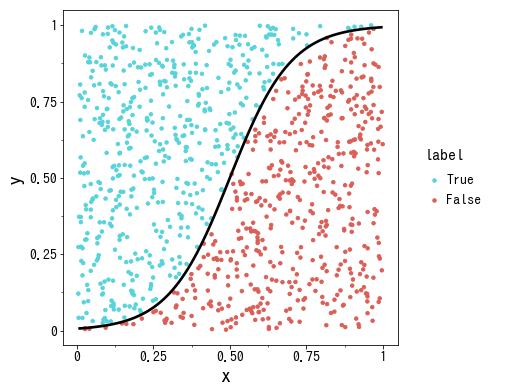

<ggplot: (8773414981384)>


In [4]:
g = ggplot(df) + geom_point(aes(x='x', y='y', color='label'))
g += scale_color_discrete(breaks=[True, False])
g += stat_function(fun=logisCurve, size=1.5)
print(g)

In [50]:
import numpy as np
import pandas as pd

# 実演用データ作成
np.random.seed(42)
n = 1000
# 実際の境界線
logisCurve = lambda x: expit((x - .5) * 10)
# データ
df = pd.DataFrame({'x': np.random.uniform(low=0, high=1, size=n),
                   'y': np.random.uniform(low=0, high=1, size=n)
                  })
df['label'] = logisCurve(df['x']) <= df['y']

/home/ks/.pyenv/versions/3.6.5/lib/python3.6/site-packages/plotnine/utils.py:281: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  ndistinct = ids.apply(len_unique, axis=0).as_matrix()
/home/ks/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/core/generic.py:4384: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/home/ks/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/core/generic.py:4385: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


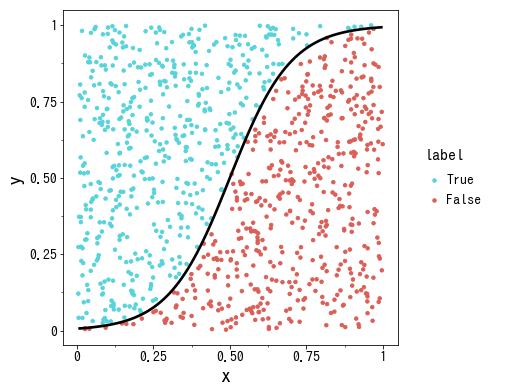

<ggplot: (8773410740677)>


In [53]:
from plotnine import (ggplot, aes, geom_point, stat_function, scale_color_discrete)
g = ggplot(df) + geom_point(aes(x='x', y='y', color='label'))
g += scale_color_discrete(breaks=[True, False])
g += stat_function(fun=logisCurve, size=1.5)
print(g)

In [54]:
# 計画行列
X = df[['x', 'y']].values
# ラベル
y = df['label'].values

In [55]:
# hot pot
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
hotpot = Pipeline([('standardize', StandardScaler()), ('HotPot', SVC())])
hotpot.fit(X, y)

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('HotPot', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

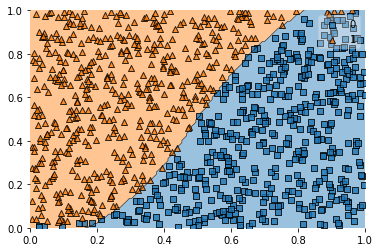

In [56]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
fig, ax = plt.subplots()
plot_decision_regions(X, (y==True)*1, hotpot, ax=ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.figure.savefig(Path().cwd() / 'hotpot_regions.pdf')